# ECMWF Storm Data Processing

This notebook demos how to use the functions in `src/ocha_lens/datasources/ecmwf_storm.py`

In [1]:
from datetime import datetime

import geopandas as gpd
from shapely.geometry import LineString

import ocha_lens as lens

Access the `cxml` datasets saved to Azure blob and store as a dataframe. We'll get the forecasts in March 2019 (cyclone Idai).

In [2]:
df = lens.ecmwf_storm.load_hindcasts(
    start_date=datetime(2024, 11, 1),
    end_date=datetime(2024, 11, 5),
    use_cache=False,
    skip_if_missing=False,
    stage="local",
)

Processing for 2024-11-01 00:00:00...
Processing for 2024-11-01 12:00:00...
Processing for 2024-11-02 00:00:00...
Processing for 2024-11-02 12:00:00...
Processing for 2024-11-03 00:00:00...
Processing for 2024-11-03 12:00:00...
Processing for 2024-11-04 00:00:00...
Processing for 2024-11-04 12:00:00...
Processing for 2024-11-05 00:00:00...


Process this dataframe into the `storms` and `forecast_track` standards

In [3]:
df_storms, gdf_forecasts = lens.ecmwf_storm.get_storms_and_tracks(df)

In [4]:
df_storms.head(3)

,name,number,storm_id,provider,season,basin
8,RAFAEL,18L,RAFAEL_North Atlantic_2024,ecmf,2024,North Atlantic
9,YINXING,28W,YINXING_Northwest Pacific_2024,ecmf,2024,Northwest Pacific
6,PATTY,17L,PATTY_North Atlantic_2024,ecmf,2024,North Atlantic


In [5]:
gdf_forecasts.head(3)

,issued_time,id,basin,leadtime,valid_time,pressure,wind_speed,season,storm_id,point_id,geometry
0,2024-11-01,2024110100_264N_1204E,Northwest Pacific,0,2024-11-01 00:00:00+00:00,991.0,22.1,2024.0,KONG-REY_Northwest Pacific_2024,f018d5d1-857f-4e22-b050-2359dc7fb1e9,POINT (120.5 26.4)
1,2024-11-01,2024110100_264N_1204E,Northwest Pacific,6,2024-11-01 06:00:00+00:00,994.0,23.2,2024.0,KONG-REY_Northwest Pacific_2024,02a597dc-f21b-4bb8-bded-2e8da0e146ab,POINT (121.6 28)
2,2024-11-01,2024110100_264N_1204E,Northwest Pacific,12,2024-11-01 12:00:00+00:00,998.0,19.6,2024.0,KONG-REY_Northwest Pacific_2024,a8b6828f-a612-4b72-805c-65e370b59a2f,POINT (123.3 30.2)


A very basic plot of the forecast tracks that we've defined as a storm.

<Axes: >

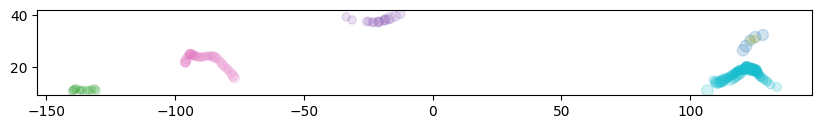

In [6]:
gdf_forecasts.plot(
    column="storm_id",
    markersize=df["wind_speed"] * 3,
    legend=False,
    figsize=(10, 8),
    alpha=0.2,
)

And do a simple transformation of all points into tracks. We can see the IDs are unique as we'd expect here...

/var/folders/rv/xmclt0vn5y7cqt46s5xq3h080000gn/T/ipykernel_95898/498382144.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: LineString([(pt.x, pt.y) for pt in x.geometry]))


<Axes: >

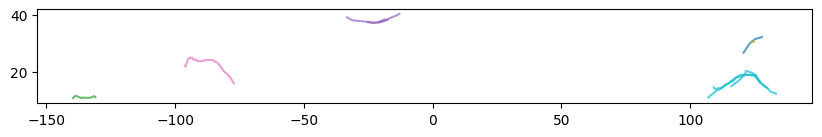

In [7]:
tracks = (
    gdf_forecasts.sort_values("valid_time")
    .groupby(["storm_id", "id"])
    .apply(lambda x: LineString([(pt.x, pt.y) for pt in x.geometry]))
    .reset_index(name="geometry")
)


tracks_gdf = gpd.GeoDataFrame(tracks, crs=gdf_forecasts.crs)
track_attrs = gdf_forecasts.groupby("storm_id").first().reset_index()
tracks_gdf = tracks_gdf.merge(
    track_attrs[["storm_id", "basin"]], on="storm_id"
)

tracks_gdf.plot(
    column="storm_id",
    legend=False,
    alpha=0.7,
    figsize=(10, 10),
)